# Anomaly Detection Feature Study
## 0. Prerequisites
### Data
High-level features from DelphesHerwig (background) and DelphesPythia (background, W' signal)

In [6]:
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm

## 1. Loading Data

In [7]:
filenames = {
    "herwig": "GAN-data\events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]

df = {}

### Sort leading vs. subleading jets by jet mass

In [8]:
def load_data(datatype):
    input_frame = pd.read_hdf(filenames[datatype])
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["pj1"] = np.sqrt(output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["pj2"] = np.sqrt(output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pzj1"] + output_frame["pzj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [9]:
for datatype in tqdm(datatypes):
    df[datatype] = load_data(datatype)

100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


In [11]:
for datatype in datatypes:
    print(datatype+":")
    print(df[datatype].info(memory_usage=True))
    print()

herwig:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 999999 entries, 0 to 999998
Data columns (total 25 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   pxj1     999999 non-null  float64
 1   pyj1     999999 non-null  float64
 2   pzj1     999999 non-null  float64
 3   mj1      999999 non-null  float64
 4   tau1j1   999999 non-null  float64
 5   tau2j1   999999 non-null  float64
 6   tau3j1   999999 non-null  float64
 7   pxj2     999999 non-null  float64
 8   pyj2     999999 non-null  float64
 9   pzj2     999999 non-null  float64
 10  mj2      999999 non-null  float64
 11  tau1j2   999999 non-null  float64
 12  tau2j2   999999 non-null  float64
 13  tau3j2   999999 non-null  float64
 14  pj1      999999 non-null  float64
 15  pj2      999999 non-null  float64
 16  ej1      999999 non-null  float64
 17  ej2      999999 non-null  float64
 18  ejj      999999 non-null  float64
 19  pjj      999999 non-null  float64
 20  mjj      999999 no

In [16]:
inds = pd.isnull(df["herwig"]).any(1).to_numpy().nonzero()
df["herwig"].iloc[inds].loc[:, ['tau1j1', 'tau2j1', 'tau3j1', 'tau21j1', 'tau32j1', 'mj1', 'tau1j2', 'tau2j2', 'tau3j2', 'tau21j2', 'tau32j2', 'mj2']]

,tau1j1,tau2j1,tau3j1,tau21j1,tau32j1,mj1,tau1j2,tau2j2,tau3j2,tau21j2,tau32j2,mj2
33221,27.323000,16.941099,12.335900,0.620031,0.728164,126.320000,0.203080,0.000000,0.0000,0.000000,NaN,3.825730
38670,20.209900,16.672001,14.146900,0.824942,0.848542,60.343399,0.574639,0.000000,0.0000,0.000000,NaN,1.808560
53576,51.512100,32.992802,18.036800,0.640486,0.546689,87.323898,0.983826,0.000000,0.0000,0.000000,NaN,1.001860
63541,399.524994,192.171005,96.247902,0.480999,0.500845,438.196991,0.000000,0.000000,0.0000,NaN,NaN,-0.000031
314267,49.617699,34.109798,27.757299,0.687452,0.813763,100.362999,1.009500,0.000000,0.0000,0.000000,NaN,3.334120
356099,97.820198,60.769501,40.301300,0.621237,0.663183,190.709000,3.883060,0.000000,0.0000,0.000000,NaN,9.287530
406107,39.367599,0.000000,0.000000,0.000000,NaN,69.417999,33.442299,21.407801,14.0909,0.640141,0.658213,66.801399
435821,307.858002,94.302803,67.966499,0.306319,0.720726,518.632019,5.339250,0.000000,0.0000,0.000000,NaN,20.677799
504740,28.733500,14.896700,12.336300,0.518444,0.828123,99.542801,21.131901,0.000000,0.0000,0.000000,NaN,47.237099
682072,48.375000,14.031000,8.227990,0.290047,0.586415,70.010002,0.501444,0.000000,0.0000,0.000000,NaN,6.303630


In [14]:
inds = pd.isnull(df["pythiabg"]).any(1).to_numpy().nonzero()
df["pythiabg"].iloc[inds].loc[:, ['tau1j1', 'tau2j1', 'tau3j1', 'tau21j1', 'tau32j1', 'mj1', 'tau1j2', 'tau2j2', 'tau3j2', 'tau21j2', 'tau32j2', 'mj2']]

,tau1j1,tau2j1,tau3j1,tau21j1,tau32j1,mj1,tau1j2,tau2j2,tau3j2,tau21j2,tau32j2,mj2
2479,78.031197,27.617901,11.207100,0.353934,0.405791,210.289001,0.193714,0.0,0.0,0.0,NaN,12.995800
7980,9.850570,9.360730,7.421170,0.950273,0.792798,51.298199,0.094450,0.0,0.0,0.0,NaN,3.299670
17400,195.550003,82.173203,57.232201,0.420216,0.696483,328.171997,0.000000,0.0,0.0,NaN,NaN,-0.000015
25398,23.229900,11.379300,9.381190,0.489856,0.824408,71.516800,0.000000,0.0,0.0,NaN,NaN,0.000000
35386,17.702600,2.483840,1.288870,0.140309,0.518902,46.236698,0.000000,0.0,0.0,NaN,NaN,-0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...
969528,54.202900,17.223000,15.088800,0.317751,0.876084,87.207703,0.000000,0.0,0.0,NaN,NaN,-0.000022
989235,14.598400,9.308350,7.643760,0.637628,0.821172,37.067101,0.000000,0.0,0.0,NaN,NaN,0.000000
989483,36.858299,22.140600,16.136499,0.600695,0.728819,141.830002,0.000000,0.0,0.0,NaN,NaN,0.000000
991932,307.914001,79.351196,50.545700,0.257706,0.636987,366.824005,5.905240,0.0,0.0,0.0,NaN,65.560997


In [15]:
inds = pd.isnull(df["pythiasig"]).any(1).to_numpy().nonzero()
df["pythiasig"].iloc[inds].loc[:, ['tau1j1', 'tau2j1', 'tau3j1', 'tau21j1', 'tau32j1', 'mj1', 'tau1j2', 'tau2j2', 'tau3j2', 'tau21j2', 'tau32j2', 'mj2']]

,tau1j1,tau2j1,tau3j1,tau21j1,tau32j1,mj1,tau1j2,tau2j2,tau3j2,tau21j2,tau32j2,mj2
2709,359.351990,48.898701,30.676901,0.136075,0.627356,546.062988,0.000000,0.0,0.0,NaN,NaN,0.000000
9448,55.429199,27.687300,18.474100,0.499507,0.667241,100.244003,0.000000,0.0,0.0,NaN,NaN,-0.000011
14057,106.806999,41.003300,32.484001,0.383901,0.792229,115.160004,0.000000,0.0,0.0,NaN,NaN,0.000000
17698,64.236397,19.571301,13.272500,0.304676,0.678161,102.777000,0.000000,0.0,0.0,NaN,NaN,0.000008
20648,366.833008,130.860001,64.044701,0.356729,0.489414,483.404999,0.000000,0.0,0.0,NaN,NaN,-0.000015
21386,290.500000,140.947998,66.550400,0.485191,0.472163,464.190002,0.000000,0.0,0.0,NaN,NaN,0.000000
21861,66.840202,37.861500,27.660500,0.566448,0.730571,164.173004,0.000000,0.0,0.0,NaN,NaN,-0.000031
25191,168.880997,96.098503,36.388199,0.569031,0.378655,306.058014,0.399067,0.0,0.0,0.0,NaN,12.807400
30132,68.980003,30.220100,16.307899,0.438099,0.539638,98.523499,0.000000,0.0,0.0,NaN,NaN,-0.000031
33258,141.983994,89.132103,58.809399,0.627762,0.659800,229.929001,3.975920,0.0,0.0,0.0,NaN,49.032299


## 2. Plot Features
### Jet Masses

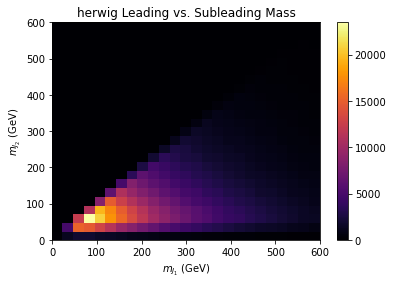

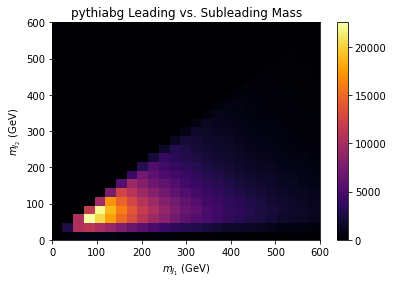

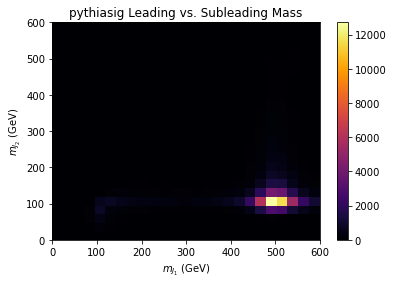

In [9]:
for datatype in datatypes:
    plt.title(datatype + " Leading vs. Subleading Mass")
    plt.ylabel("$m_{J_2}$ (GeV)")
    plt.xlabel("$m_{J_1}$ (GeV)")
    plt.hist2d(df[datatype]["mj1"], df[datatype]["mj2"], bins = 25, range = [[0,600],[0,600]], cmap = 'inferno')
    plt.colorbar()
    plt.show()

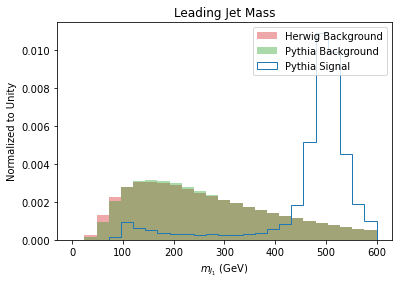

In [10]:
plt.title("Leading Jet Mass")
plt.ylabel("Normalized to Unity")
plt.xlabel("$m_{J_1}$ (GeV)")
plt.hist(df["herwig"]["mj1"], bins = 25, range = (0, 600), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["mj1"], bins = 25, range = (0, 600), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["mj1"], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

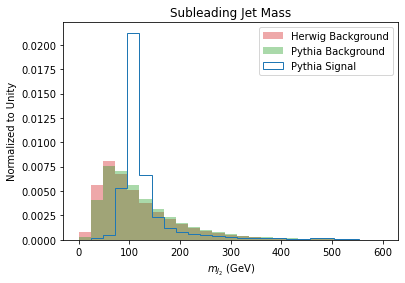

In [11]:
plt.title("Subleading Jet Mass")
plt.ylabel("Normalized to Unity")
plt.xlabel("$m_{J_2}$ (GeV)")
plt.hist(df["herwig"]["mj2"], bins = 25, range = (0, 600), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["mj2"], bins = 25, range = (0, 600), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["mj2"], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

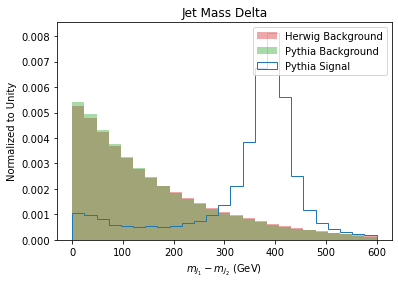

In [12]:
plt.title("Jet Mass Delta")
plt.ylabel("Normalized to Unity")
plt.xlabel("$m_{J_1}-m_{J_2}$ (GeV)")
plt.hist(df["herwig"]["mj1"] - df["herwig"]["mj2"], bins = 25, range = (0, 600), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["mj1"] - df["pythiabg"]["mj2"], bins = 25, range = (0, 600), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["mj1"] - df["pythiasig"]["mj2"], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

### Jet Energies

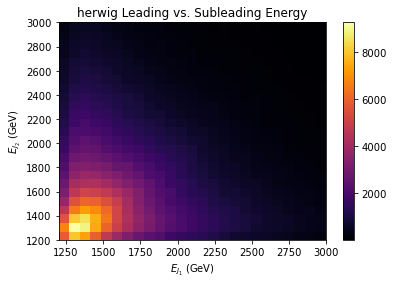

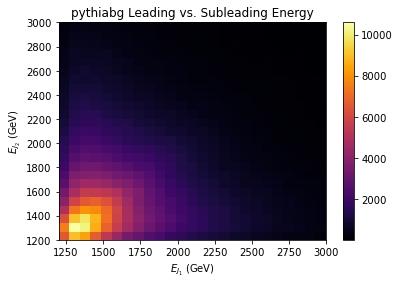

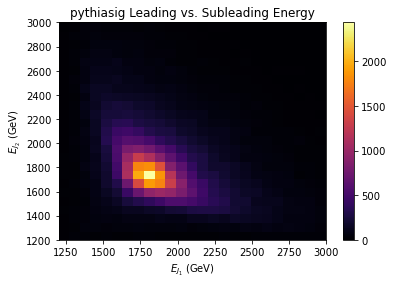

In [13]:
for datatype in datatypes:
    plt.title(datatype + " Leading vs. Subleading Energy")
    plt.ylabel("$E_{J_2}$ (GeV)")
    plt.xlabel("$E_{J_1}$ (GeV)")
    plt.hist2d(df[datatype]["ej1"], df[datatype]["ej2"], bins = 25, range = [[1200,3000],[1200,3000]], cmap = 'inferno')
    plt.colorbar()
    plt.show()

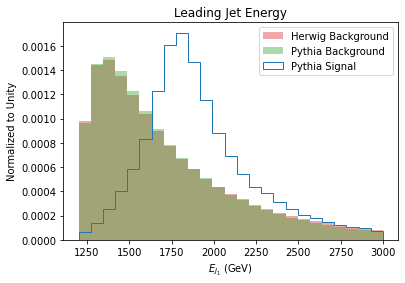

In [14]:
plt.title("Leading Jet Energy")
plt.ylabel("Normalized to Unity")
plt.xlabel("$E_{J_1}$ (GeV)")
plt.hist(df["herwig"]["ej1"], bins = 25, range = (1200, 3000), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["ej1"], bins = 25, range = (1200, 3000), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["ej1"], bins = 25, range = (1200, 3000), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

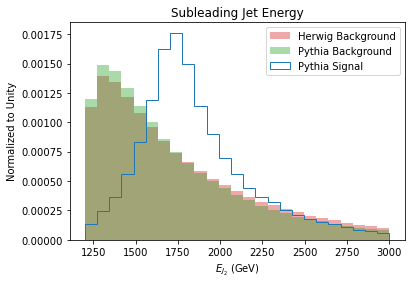

In [15]:
plt.title("Subleading Jet Energy")
plt.ylabel("Normalized to Unity")
plt.xlabel("$E_{J_2}$ (GeV)")
plt.hist(df["herwig"]["ej2"], bins = 25, range = (1200, 3000), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["ej2"], bins = 25, range = (1200, 3000), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["ej2"], bins = 25, range = (1200, 3000), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

### Dijet Mass & Energy

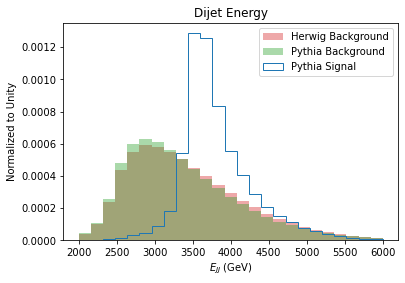

In [16]:
plt.title("Dijet Energy")
plt.ylabel("Normalized to Unity")
plt.xlabel("$E_{JJ}$ (GeV)")
plt.hist(df["herwig"]["ejj"], bins = 25, range = (2000, 6000), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["ejj"], bins = 25, range = (2000, 6000), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["ejj"], bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

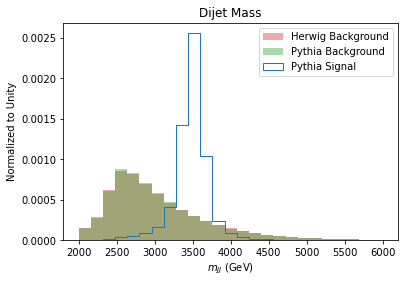

In [17]:
plt.title("Dijet Mass")
plt.ylabel("Normalized to Unity")
plt.xlabel("$m_{JJ}$ (GeV)")
plt.hist(df["herwig"]["mjj"], bins = 25, range = (2000, 6000), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["mjj"], bins = 25, range = (2000, 6000), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["mjj"], bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

### N-Subjettiness Ratio

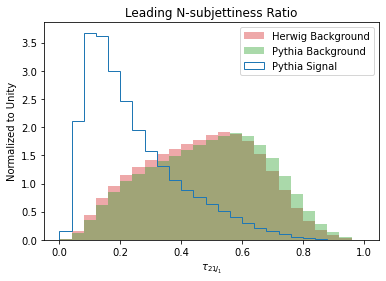

In [18]:
plt.title("Leading N-subjettiness Ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("$\\tau_{21J_1}$")
plt.hist(df["herwig"]["tau21j1"], bins = 25, range = (0, 1), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["tau21j1"], bins = 25, range = (0, 1), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["tau21j1"], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

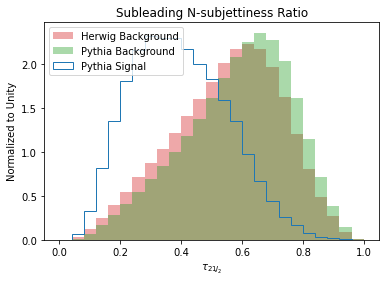

In [19]:
plt.title("Subleading N-subjettiness Ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("$\\tau_{21J_2}$")
plt.hist(df["herwig"]["tau21j2"], bins = 25, range = (0, 1), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["tau21j2"], bins = 25, range = (0, 1), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["tau21j2"], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

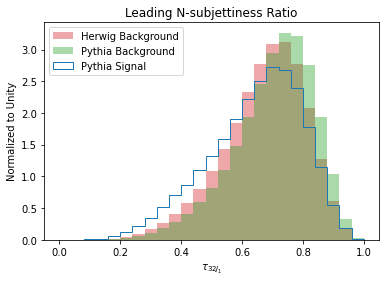

In [20]:
plt.title("Leading N-subjettiness Ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("$\\tau_{32J_1}$")
plt.hist(df["herwig"]["tau32j1"], bins = 25, range = (0, 1), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["tau32j1"], bins = 25, range = (0, 1), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["tau32j1"], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()

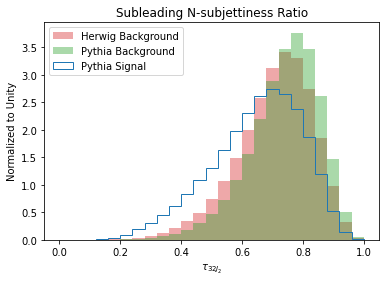

In [21]:
plt.title("Subleading N-subjettiness Ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("$\\tau_{32J_2}$")
plt.hist(df["herwig"]["tau32j2"], bins = 25, range = (0, 1), color = "tab:red", alpha = 0.4, label = "Herwig Background", density = True)
plt.hist(df["pythiabg"]["tau32j2"], bins = 25, range = (0, 1), color = "tab:green", alpha = 0.4, label = "Pythia Background", density = True)
plt.hist(df["pythiasig"]["tau32j2"], bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "Pythia Signal", density = True)
plt.legend()
plt.show()